# Text Analysis

This notebook applies text analysis techniques to a dataset of tweets to `@apple`, exploring sentiment and word frequencies.

A small amount of processing has already been carried out on the data, removing URLs from the tweets and selecting an interesting subset of columns.

## Setup

### Library imports

In [ ]:
import nltk  # Word lists
import pandas as pd  # Manage datasets
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Sentiment in social media
import seaborn as sns  # Plotting
from nltk.tokenize import word_tokenize  # Split text into words
from nltk.corpus import stopwords  # Lists of unimportant words
from collections import Counter  # Count word frequency
import matplotlib.pyplot as plt  # Visualisation
from wordcloud import WordCloud  # Wordclouds
from pandas.core.common import flatten  # Collapse lists of lists

In [ ]:
# Download word lists

nltk.download("all")

### Sourcing the data

In [3]:
tweets = pd.read_csv("apple_tweets.csv")

## Data exploration

### Viewing the dataset

In [4]:
# How many tweets?

tweets.shape

(9991, 7)

In [5]:
# View a sample

tweets.sample(3)

,created_at,screen_name,text,favorite_count,retweet_count,verified,followers_count
8756,1548618634,george51016066,"@Apple Nice, i want the note 9",2,0,False,2
6565,1548717997,tootsie232,@Apple Let’s talk about this FaceTime thing th...,5,0,False,85
5544,1548564188,ilyabelikin,@ARJWright As far as I digged @Apple did provi...,0,0,False,329


#### Learner challenge: summary statistics

Display:

1. The average number of retweets
2. The maximum number of followers
3. The most common screen_name
4. The number of tweets with more than 50 likes

In [6]:
# Mean retweets

print(tweets["retweet_count"].mean())

# Maximum followers

print(tweets["followers_count"].max())

# Most common screen_name

print(tweets["screen_name"].value_counts().index[0])

# Number of tweets with more than 50 likes

print(tweets[tweets["favorite_count"] > 50].shape[0])

0.3312981683515164
11544927
Chappers2013
36


### Examining the text

In [7]:
# Select a single row by index location, and view just the text.
# This gets around display width limits.

tweets.iloc[680]["text"]

'✨🍎@Apple : Apple was warned about the FaceTime eavesdropping bug last week  #Tech #Apple $AAPL #Technology #TechNews '

In [8]:
# Set the column display width to a more useful value for working with text

pd.set_option('display.max_colwidth', 500)

# There are lots of different settable options; it's worth experimenting with them

In [9]:
# View the text but more easily now

tweets.sample()

,created_at,screen_name,text,favorite_count,retweet_count,verified,followers_count
1301,1548568126,Chris__Guillen,"Apple TV Siri command, ""Route Audio to AirPods"" would be nice @Apple @tim_cook",0,0,False,444


## Sentiment Analysis

Vader is a sentiment analysis tool that is designed to work with social media data; we don't need to do any cleaning before using it.

In [10]:
# Create a sentiment-analysing object

vader = SentimentIntensityAnalyzer()

In [11]:
# Example of scoring

vader.polarity_scores("I am VERY sad!")

{'neg': 0.688, 'neu': 0.312, 'pos': 0.0, 'compound': -0.6617}

`.polarity_scores(text)` returns a dictionary of four values. The important one is "compound". This is a score between -1 (very negative) and 1 (very positive) for the whole text.

In [12]:
# Apply the sentiment analyser to the entire dataset

def get_sentiment(text):
    return vader.polarity_scores(text)["compound"]

tweets["sentiment"] = tweets["text"].apply(get_sentiment)

# Create a new column; each value in the column is the result of passing the text of that row
# through the sentiment analyser and selecting the "compound" attribute.

In [13]:
# Check the data

tweets.tail(2)

,created_at,screen_name,text,favorite_count,retweet_count,verified,followers_count,sentiment
9989,1548549477,nuke4869,@CourtMejias @raymondchung @Apple @Honda @Toyota Go check Tesla,0,0,False,245,0.0
9990,1548549398,leonugent,Throws @GoogleUK @AmazonUK @Apple into focus #tax #avoidance #sucks - UK's 'highest taxpayers' revealed in first-ever Sunday Times list,0,0,False,921,0.0


#### Learner challenge: view the most positive/negative tweets

In [14]:
# View the most positive tweets

tweets.sort_values(by="sentiment", ascending=False).head(3)

,created_at,screen_name,text,favorite_count,retweet_count,verified,followers_count,sentiment
1082,1548831715,fexiona,@Apple My sibling has it is so good and its a high price but still is so good i mean is almost like iphone x models so cool love it haha,0,0,False,5,0.9788
3604,1548779687,RadhanMohammed,@Apple\n@tim_cookI Haven't Used An Apple IPhone Yet &amp; I Hope That I'll Use This World Best Ever Design Of Apple For First &amp; It Will The Most Proudest &amp; Most Happiest Moment In My Life Please. 😌 🙏. \n\nBest Smart Phone Ever In The Market.,1,1,False,23,0.9769
9158,1548601502,ruinsoares,"@nytorv @Apple @tim_cook Completely agree; Xs Max is an amazing phone and a marvelous, fantastic, amazing camera! In any light conditions! Superb experience!",0,0,False,92,0.9746


#### Learner challenge: create a dist plot; what does it suggest?

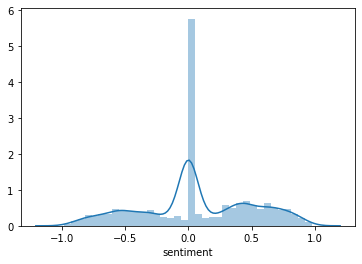

In [15]:
# View the distribution of sentiment in the dataset

sns.distplot(tweets["sentiment"])

Many of the tweets have neutral or mild sentiment, and aren't really interesting from a sentiment perspective. This is common for text data.

#### Learner challenge: categorise the tweets based on their sentiment

In [16]:
# Add a positive/negative/neutral label to each tweet

def get_sentiment_type(score):
    if score >= 0.3:
        return "positive"
    elif score <= -0.3:
        return "negative"
    else:
        return "neutral"

tweets["sentiment_type"] = tweets["sentiment"].apply(get_sentiment_type)

In [17]:
# Check the data

tweets[["text", "sentiment", "sentiment_type"]].sample(2)

,text,sentiment,sentiment_type
2889,Can you fix FaceTime please @Apple,0.3182,positive
779,@Apple Happy with my new MI A2 @XiaomiIndia,0.5719,positive


## Exploring word frequency

### Preprocessing

We'll preserve the `text` column exactly as it is, in case we want to come back to it later.

In [18]:
# Create a new text column

tweets["clean_text"] = tweets["text"]

In [19]:
# Drop the clean column to lowercase

tweets["clean_text"] = tweets["clean_text"].str.lower()

### Regular expressions

Regular expressions let you find patterns in text. You can experiment with them using [Regexr](https://regexr.com) and practice them at [Regex Crossword](https://regexcrossword.com/).

| Syntax | Meaning |
| --- | --- |
| \w | Any alphanumeric character |
| \s | Any space character |
| [] | Any one character inside the brackets |
| [^] | Any one character except those inside the brackets |
| + | As many as possible of the previous character |

In [20]:
# Remove the mentions and hashtags using regular expressions

tweets["clean_text"] = tweets["clean_text"].replace(r"[@#]\w+", " ", regex=True)

In [21]:
# Collapse extra spaces

tweets["clean_text"] = tweets["clean_text"].replace(r" +", " ", regex=True)

In [22]:
# Compare the cleaned text to the original

tweets[["text", "clean_text"]].sample()

,text,clean_text
7925,"Dear @Apple. Please get rid of that proprietary Lightning port on the 2019 #iPhone and replace it with USB-C. You've already done it with the #iPad Pro so at least we know it's possible. While you're there, lower the price as well. It might just help increase sales. Thanks.","dear . please get rid of that proprietary lightning port on the 2019 and replace it with usb-c. you've already done it with the pro so at least we know it's possible. while you're there, lower the price as well. it might just help increase sales. thanks."


### Tokenisation

Splitting the text into individual words - or **tokens** - lets us process the text in a new way.

In [23]:
# Create a tokens column

tweets["tokens"] = tweets["clean_text"].apply(word_tokenize)

In [24]:
# Always check the data after transformations

tweets["tokens"].sample(3)

3686                                                                                                               [apple, has, made, the, group, chat, function, in, facetime, unavailable, after, users, said, there, was, a, bug, that, could, allow, callers, to, activate, another, user, 's, microphone, remotely, .]
1797                                                                                                                                                                                                                               [yeah, i, do, n't, see, any, ambiguity, here, but, waiting, to, hear, back, from, apple]
5956    [actually, ,, you, told, siri, that, ., check, out, your, settings, for, mapping, directions, ., i, believe, that, you, have, it, set, for, the, default, as, drive, not, walk, ., unfortunately, ,, siri, and, maps, is, not, able, to, give, the, most, human, –, efficient, route, ,, at, this, time, at, least]
Name: tokens, dtype: object

### Removing stopwords

"Stopwords" are small functional words - like "the" or "of" - that don't add much to our analysis.

In [25]:
# Get a list of stopwords

stops = stopwords.words("english")

# Add words to the stop list that are not interesting in this context

stops.extend(["apple", "aapl", "phone", "iphone", "..."])

In [26]:
# Filter each tweet, removing stopwords

def stop_remove(word_list):
    return [word for word in word_list if word not in stops]

tweets["tokens"] = tweets["tokens"].apply(stop_remove)

#### Learner challenge: remove all words with under three characters

In [27]:
# Remove all words with fewer than 3 characters

def short_remove(word_list):
    return [word for word in word_list if len(word) > 2]

tweets["tokens"] = tweets["tokens"].apply(short_remove)

In [28]:
# Check the keywords

tweets["tokens"].sample(3)

8441                     [going, fuckup, others, make, money]
3434                         [new, enter, 100.00, gift, card]
770     [may, support, smart, keyboard, better, productivity]
Name: tokens, dtype: object

## Calculating frequency

In [29]:
# Select the data we want to analyse

data = tweets["tokens"][tweets["sentiment_type"] == "positive"]

# We could subset here into just positive tweets, or only those by verified users, etc.

In [30]:
# Join all the tokens together into a list of lists

token_col = data.to_list()

# Flatten the list into a single list of tokens

tokens = list(flatten(token_col))

In [31]:
# Count how many times each token appears

token_counts = Counter(tokens)

In [32]:
# Convert the counter dictionary into a sortable series

token_counts = pd.Series(token_counts)

### Visualise the top 20 words

#### Learner challenge: select only the 20 most frequent terms

In [33]:
# Get the top 20 terms

top_twenty = token_counts.sort_values(ascending=False)[:20]

#### Learner challenge: create a barplot of terms & frequencies

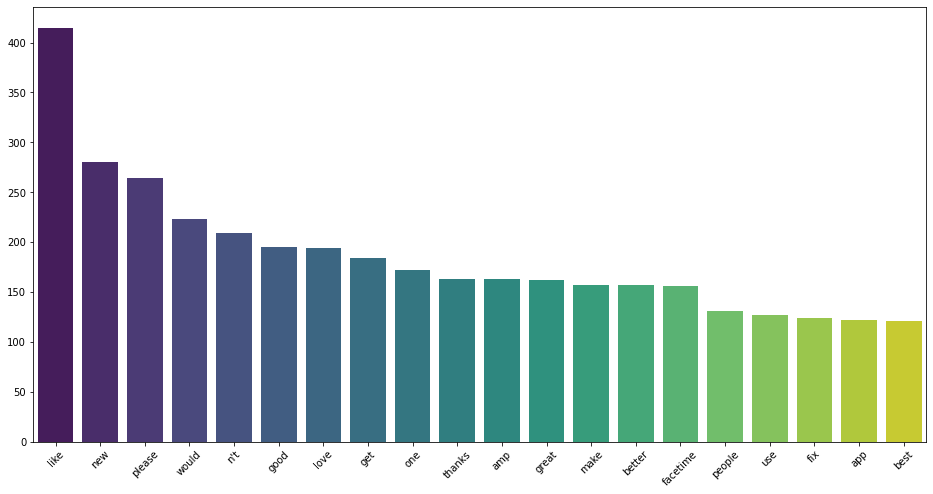

In [34]:
# Plot them as a barplot
plt.figure(figsize=(16, 8))
plt.xticks(rotation=45)
sns.barplot(x=top_twenty.index, y=top_twenty, palette="viridis")

#### Learner challenge (advanced): create a wordcloud

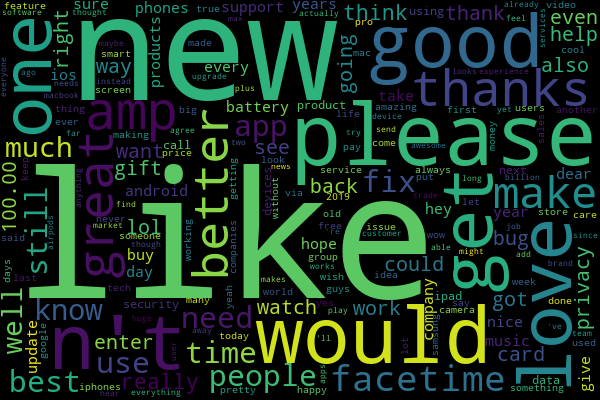

In [35]:
# Build a wordcloud object

fog_machine = WordCloud(width=600, height=400)

fog_machine.generate_from_frequencies(token_counts)

fog_machine.to_image()